# Github pour processer le dataset téléchargé : https://github.com/Mr-TalhaIlyas/Prerpcessing-PanNuke-Nuclei-Instance-Segmentation-Dataset/tree/master

In [1]:
from metrics_hover_net import * 
import os
import numpy as np
import geojson
import pandas as pd
import matplotlib.pyplot as mp
from function_masks_PANNUKE import *
import imageio.v3 as iio

In [2]:
PATH_raw = '/media/user/Watson/PanNuke/processed/'
PATH = '/media/user/Watson/PanNuke/normalisation_study/'
PATH_metrics = '/media/user/Watson/PanNuke/metrics/Segmentation/'
organs = ['Adrenal_gland', 'Bile-duct', 'Bladder', 'Breast', 'Cervix', 'Colon', 'Esophagus', 'HeadNeck', 'Kidney', 'Liver', 'Lung', 'Ovarian', 'Pancreatic', 'Prostate', 'Skin', 'Stomach', 'Testis', 'Thyroid', 'Uterus']

['Adrenal_gland', 'Bile-duct', 'Bladder', 'Breast', 'Cervix', 'Colon', 'Esophagus', 'HeadNeck', 'Kidney', 'Liver', 'Lung', 'Ovarian', 'Pancreatic', 'Prostate', 'Skin', 'Stomach', 'Testis', 'Thyroid', 'Uterus']
14


In [3]:
methods = ['GeomLoss_sinkhorn_target',
 'Reinhard',
 'Ruifrok',
 'GeomLoss_sinkhorn_gradient',
 'model_GAN',
 'model_Net',
 'Macenko',
 'GeomLoss_sinkhorn_Average',
 'GeomLoss_gaussian_Average',
 'Vahadane',
]

['GeomLoss_sinkhorn_target',
 'model_GAN_1',
 'model_Net_1',
 'original',
 'Reinhard',
 'Ruifrok',
 'GeomLoss_sinkhorn_gradient',
 'model_GAN',
 'model_Net',
 'Macenko',
 'GeomLoss_sinkhorn_Average',
 'GeomLoss_gaussian_Average',
 'Vahadane',
 'OT_1D']

# Segmentation

In [8]:
width, height = 256,256

In [9]:
from scipy import misc,ndimage
def dissociate_mask(img) : 
    label_im, nb_labels = ndimage.label(img) 
    mask_cellmasks = np.zeros((width, height), dtype = int)
    for i in range(nb_labels):
        mask_compare = np.full(np.shape(label_im), i) 

        # check equality test and have the value 1 on the location of each mask
        separate_mask = np.equal(label_im, mask_compare).astype(int) 

        # replace 1 with 255 for visualization as rgb image

        separate_mask[separate_mask == 1] = i+1
    
        separate_mask = np.multiply(i, separate_mask)
        
        mask_cellmasks += separate_mask
        

    
    mask_cellmasks = np.array(mask_cellmasks)

    return mask_cellmasks

In [10]:
len(methods)

9

In [11]:
PATH_metrics = '/media/user/Watson/PanNuke/metrics/Segmentation/'

In [13]:
for method in methods :# ['model_GAN', 'model_Net'] :
    if not os.path.exists(PATH_metrics+method+'.csv') :
        df = pd.DataFrame()#{'method' :[methods[0]]*5+[methods[1]]*5+[methods[2]]*5+[methods[3]]*5+[methods[4]]*5+[methods[5]]*5+[methods[6]]*5, 'dataset':datasets*7})

        print('--------------'+method+'--------------')
        for dataset in datasets :
            print(dataset)
            jaccard_list = []
            dice_list = []
            patches = os.listdir(PATH+method+'/hovernet/'+dataset+'/json/')
            
            liste_aji = []
            liste_aji_plus = []
            liste_dice_1 = []
            liste_dice_2 = []
            liste_pq = []
            liste_sq = []
            liste_dq = []
            
            for patch in patches :
                PATH_tot = PATH+method+'/hovernet/'+dataset+'/json/'+patch
                if dataset == 'Colon' and PATH_tot == '/media/user/Watson/PanNuke/normalisation_study/GeomLoss_sinkhorn_Average/hovernet/Colon/json/img_Colon_2_00703.json' :
                    continue
                else :
                    with open(PATH_tot) as f :
                        try :
                            nuclei = geojson.load(f)
                        except JSONDecodeError :
                            continue
                        nuclei = nuclei['nuc']
                    img_pred = function_mask_binary_continuous_IDs(nuclei)
                    img_true = iio.imread(PATH_raw + dataset+'/sem_masks/sem'+patch[3:-4]+'png')
                    img_true = dissociate_mask(img_true)

                    pt = img_true.copy() 
                    pt = remap_label(pt)
                    p = img_pred.copy()
                    p = remap_label(p)

                    if len(np.unique(p)) == 1 or len(np.unique(pt)) == 1 :
                            pass
                    else:

                        aji = get_fast_aji(pt,p)
                        aji_plus = get_fast_aji_plus(pt,p)
                        dice_1 = get_dice_1(pt,p)
                        try :
                            dice_2 = get_fast_dice_2(pt,p)
                        except ZeroDivisionError:
                            dice_2 = 0
                        pq = get_fast_pq(pt,p)[0][2]
                        sq = get_fast_pq(pt,p)[0][0]
                        dq = get_fast_pq(pt,p)[0][1]

                        liste_aji.append(aji)
                        liste_aji_plus.append(aji_plus)
                        liste_dice_1.append(dice_1)
                        liste_dice_2.append(dice_2)
                        liste_pq.append(pq)  
                        liste_sq.append(sq)
                        liste_dq.append(dq)  

            data = {'method' : [method], 'dataset' : [dataset], 'aji' : [np.mean(liste_aji)], 'aji+' : [np.nanmean(liste_aji_plus)], 'dice_1' : [np.nanmean(liste_dice_1)], 'dice_2' : [np.nanmean(liste_dice_2)], 'PQ' : [np.nanmean(liste_pq)], 'SQ' : [np.nanmean(liste_sq)], 'DQ' : [np.nanmean(liste_dq)]}
    #            data = {'method' : [method], 'dataset' : [dataset], 'SQ' : [np.nanmean(liste_sq)], 'DQ' : [np.nanmean(liste_dq)]}

            df_temp = pd.DataFrame(data)
            df = pd.concat([df, df_temp])
    df.to_csv(PATH_metrics+method+'.csv')
else :
    df = pd.read_csv(PATH_metrics+method+'.csv')

--------------GeomLoss_sinkhorn_target--------------
Adrenal_gland
Bile-duct
Bladder
Breast
Cervix
Colon
Esophagus
HeadNeck
Kidney
Liver
Lung
Ovarian
Pancreatic
Prostate
Skin
Stomach
Testis
Thyroid
Uterus
--------------Reinhard--------------
Adrenal_gland
Bile-duct
Bladder
Breast
Cervix
Colon
Esophagus
HeadNeck
Kidney
Liver
Lung
Ovarian
Pancreatic
Prostate
Skin
Stomach
Testis
Thyroid
Uterus
--------------Ruifrok--------------
Adrenal_gland
Bile-duct
Bladder
Breast
Cervix
Colon
Esophagus
HeadNeck
Kidney
Liver
Lung
Ovarian
Pancreatic
Prostate
Skin
Stomach
Testis
Thyroid
Uterus
--------------GeomLoss_sinkhorn_gradient--------------
Adrenal_gland
Bile-duct
Bladder
Breast
Cervix
Colon
Esophagus
HeadNeck
Kidney
Liver
Lung
Ovarian
Pancreatic
Prostate
Skin
Stomach
Testis
Thyroid
Uterus
--------------model_GAN--------------
Adrenal_gland
Bile-duct
Bladder
Breast
Cervix
Colon
Esophagus
HeadNeck
Kidney
Liver
Lung
Ovarian
Pancreatic
Prostate
Skin
Stomach
Testis
Thyroid
Uterus
--------------model_N

In [14]:
df

,Unnamed: 0,method,dataset,aji,aji+,dice_1,dice_2,PQ,SQ,DQ
0,0,Vahadane,Adrenal_gland,0.609842,0.610997,0.781762,0.800972,0.591702,0.701518,0.816852
1,0,Vahadane,Bile-duct,0.624702,0.626529,0.817472,0.786922,0.599828,0.723126,0.816224
2,0,Vahadane,Bladder,0.645139,0.647219,0.823959,0.832126,0.631894,0.751896,0.833177
3,0,Vahadane,Breast,0.581314,0.583318,0.786251,0.750222,0.556693,0.694955,0.787850
4,0,Vahadane,Cervix,0.628562,0.631796,0.819066,0.783402,0.599266,0.728319,0.810070
5,0,Vahadane,Colon,0.480369,0.483372,0.708679,0.654758,0.455072,0.576088,0.749411
6,0,Vahadane,Esophagus,0.585637,0.588172,0.812095,0.742897,0.558569,0.675059,0.815359
7,0,Vahadane,HeadNeck,0.474390,0.476931,0.644890,0.724700,0.469750,0.575864,0.734182
8,0,Vahadane,Kidney,0.624760,0.627690,0.825323,0.794061,0.615008,0.739324,0.822209
9,0,Vahadane,Liver,0.609040,0.610730,0.784314,0.813734,0.594670,0.705939,0.834524


In [ ]:
df.to_csv(PATH_metrics+method+'.csv')

In [16]:
df_segmentation = pd.DataFrame()
for method in methods :
    df = pd.read_csv('/media/user/Watson/PanNuke/metrics/Segmentation/without_zscore/'+method+'.csv')
    df_segmentation = pd.concat([df_segmentation, df])
df_segmentation

,Unnamed: 0,method,dataset,aji,aji+,dice_1,dice_2,PQ,SQ,DQ
0,0,GeomLoss_sinkhorn_target,Adrenal_gland,0.642586,0.643728,0.817486,0.828241,0.624685,0.733816,0.845256
1,0,GeomLoss_sinkhorn_target,Bile-duct,0.632013,0.634244,0.825888,0.791739,0.609330,0.732146,0.819229
2,0,GeomLoss_sinkhorn_target,Bladder,0.651794,0.654694,0.826308,0.841118,0.644698,0.765416,0.840949
3,0,GeomLoss_sinkhorn_target,Breast,0.599250,0.601672,0.809910,0.756290,0.574759,0.720650,0.793588
4,0,GeomLoss_sinkhorn_target,Cervix,0.640343,0.644030,0.835476,0.785240,0.613058,0.742600,0.813190
...,...,...,...,...,...,...,...,...,...,...
14,0,Vahadane,Skin,0.448053,0.451893,0.621633,0.635401,0.444962,0.540725,0.678794
15,0,Vahadane,Stomach,0.549341,0.552030,0.734963,0.762143,0.550224,0.657974,0.795093
16,0,Vahadane,Testis,0.621588,0.624309,0.819506,0.778475,0.606480,0.724322,0.829860
17,0,Vahadane,Thyroid,0.589470,0.591723,0.795265,0.785688,0.583688,0.701532,0.827701


In [17]:
df_SQ = df_segmentation[['method','dataset','SQ']]
for i, method in enumerate(methods) :
    print(method)
    df_temp = df_SQ[df_SQ['method']==method]
    df_temp.drop(columns='method',inplace=True)
    df_temp.rename(columns={'SQ':method},inplace=True)
    if i == 0:
        df = df_temp
    else :
        df = pd.merge(df_temp, df, on='dataset')
    
df.to_csv(PATH_metrics+'df_SQ.csv')

df_DQ = df_segmentation[['method','dataset','DQ']]
for i, method in enumerate(methods) :
    print(method)
    df_temp = df_DQ[df_DQ['method']==method]
    df_temp.drop(columns='method',inplace=True)
    df_temp.rename(columns={'DQ':method},inplace=True)
    if i == 0:
        df = df_temp
    else :
        df = pd.merge(df_temp, df, on='dataset')
    
df.to_csv(PATH_metrics+'df_DQ.csv')

GeomLoss_sinkhorn_target
Reinhard
Ruifrok
GeomLoss_sinkhorn_gradient
model_GAN
model_Net
Macenko
GeomLoss_sinkhorn_Average
Vahadane
GeomLoss_sinkhorn_target
Reinhard
Ruifrok
GeomLoss_sinkhorn_gradient
model_GAN
model_Net
Macenko
GeomLoss_sinkhorn_Average
Vahadane


/tmp/ipykernel_91967/1689408678.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.drop(columns='method',inplace=True)
/tmp/ipykernel_91967/1689408678.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.rename(columns={'SQ':method},inplace=True)
/tmp/ipykernel_91967/1689408678.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.drop(columns='method',inplace=True)
/tmp/ipykernel_91967/1689408678.py:6: SettingWit

In [18]:
df_aji = df_segmentation[['method','dataset','aji']]
for i, method in enumerate(methods) :
    print(method)
    df_temp = df_aji[df_aji['method']==method]
    df_temp.drop(columns='method',inplace=True)
    df_temp.rename(columns={'aji':method},inplace=True)
    if i == 0:
        df = df_temp
    else :
        df = pd.merge(df_temp, df, on='dataset')
    
df.to_csv(PATH_metrics+'df_aji.csv')

df_dice_1 = df_segmentation[['method','dataset','dice_1']]
for i, method in enumerate(methods) :
    print(method)
    df_temp = df_dice_1[df_dice_1['method']==method]
    df_temp.drop(columns='method',inplace=True)
    df_temp.rename(columns={'dice_1':method},inplace=True)
    if i == 0:
        df = df_temp
    else :
        df = pd.merge(df_temp, df, on='dataset')
    
df.to_csv(PATH_metrics+'df_dice_1.csv')

df_aji_plus = df_segmentation[['method','dataset','aji+']]
for i, method in enumerate(methods) :
    print(method)
    df_temp = df_aji_plus[df_aji_plus['method']==method]
    df_temp.drop(columns='method',inplace=True)
    df_temp.rename(columns={'aji+':method},inplace=True)
    if i == 0:
        df = df_temp
    else :
        df = pd.merge(df_temp, df, on='dataset')
    
df.to_csv(PATH_metrics+'df_aji_plus.csv')

df_pq = df_segmentation[['method','dataset','PQ']]
for i, method in enumerate(methods) :
    print(method)
    df_temp = df_pq[df_pq['method']==method]
    df_temp.drop(columns='method',inplace=True)
    df_temp.rename(columns={'PQ':method},inplace=True)
    if i == 0:
        df = df_temp
    else :
        df = pd.merge(df_temp, df, on='dataset')
    
df.to_csv(PATH_metrics+'df_PQ.csv')

df_dice_2 = df_segmentation[['method','dataset','dice_2']]
for i, method in enumerate(methods) :
    print(method)
    df_temp = df_dice_2[df_dice_2['method']==method]
    df_temp.drop(columns='method',inplace=True)
    df_temp.rename(columns={'dice_2':method},inplace=True)
    if i == 0:
        df = df_temp
    else :
        df = pd.merge(df_temp, df, on='dataset')
    
df.to_csv(PATH_metrics+'df_dice_2.csv')

GeomLoss_sinkhorn_target
Reinhard
Ruifrok
GeomLoss_sinkhorn_gradient
model_GAN
model_Net
Macenko
GeomLoss_sinkhorn_Average
Vahadane
GeomLoss_sinkhorn_target
Reinhard
Ruifrok
GeomLoss_sinkhorn_gradient
model_GAN
model_Net
Macenko
GeomLoss_sinkhorn_Average
Vahadane
GeomLoss_sinkhorn_target
Reinhard
Ruifrok
GeomLoss_sinkhorn_gradient
model_GAN
model_Net
Macenko
GeomLoss_sinkhorn_Average
Vahadane
GeomLoss_sinkhorn_target
Reinhard
Ruifrok
GeomLoss_sinkhorn_gradient
model_GAN
model_Net
Macenko
GeomLoss_sinkhorn_Average
Vahadane
GeomLoss_sinkhorn_target
Reinhard
Ruifrok
GeomLoss_sinkhorn_gradient
model_GAN
model_Net
Macenko
GeomLoss_sinkhorn_Average
Vahadane


/tmp/ipykernel_91967/3189661039.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.drop(columns='method',inplace=True)
/tmp/ipykernel_91967/3189661039.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.rename(columns={'aji':method},inplace=True)
/tmp/ipykernel_91967/3189661039.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.drop(columns='method',inplace=True)
/tmp/ipykernel_91967/3189661039.py:6: SettingWi

In [ ]:
PATH_metrics = '/media/user/Watson/PanNuke/metrics/Segmentation/'


In [20]:
df_aji = pd.read_csv(PATH_metrics+'df_aji.csv')
df_aji_plus = pd.read_csv(PATH_metrics+'df_aji_plus.csv')
df_dice_1 = pd.read_csv(PATH_metrics+'df_dice_1.csv')
df_dice_2 = pd.read_csv(PATH_metrics+'df_dice_2.csv')
df_pq = pd.read_csv(PATH_metrics+'df_PQ.csv')
df_SQ = pd.read_csv(PATH_metrics+'df_SQ.csv')
df_DQ = pd.read_csv(PATH_metrics+'df_DQ.csv')

for df in [df_aji, df_aji_plus, df_dice_1, df_dice_2, df_pq,df_SQ,df_DQ] :
    if 'Unnamed: 0' in df.columns :
        df.drop(columns='Unnamed: 0',inplace=True)
    if 'original' in df.columns :
        df.drop(columns='original',inplace=True)
#     df.drop(columns='OT_1D',inplace=True)
#     df.drop(columns='GeomLoss_gaussian_Average',inplace=True)
    df.set_index('dataset',inplace=True)

In [21]:
df_aji_plus

,Vahadane,GeomLoss_sinkhorn_Average,Macenko,model_Net,model_GAN,GeomLoss_sinkhorn_gradient,Ruifrok,Reinhard,GeomLoss_sinkhorn_target
dataset,,,,,,,,,
Adrenal_gland,0.610997,0.629496,0.629610,0.308980,0.570987,0.637924,0.371079,0.622379,0.643728
Bile-duct,0.626529,0.634438,0.622147,0.367486,0.547621,0.633378,0.442784,0.625994,0.634244
Bladder,0.647219,0.632637,0.648850,0.388464,0.531797,0.643627,0.476117,0.644000,0.654694
Breast,0.583318,0.607222,0.590371,0.540395,0.569433,0.615368,0.529655,0.602972,0.601672
Cervix,0.631796,0.641399,0.640598,0.402238,0.565078,0.632710,0.496558,0.645492,0.644030
Colon,0.483372,0.526557,0.486327,0.504157,0.474920,0.528511,0.438931,0.498708,0.511026
Esophagus,0.588172,0.593444,0.585604,0.488679,0.530832,0.592698,0.430996,0.582178,0.600280
HeadNeck,0.476931,0.567643,0.562004,0.468985,0.406628,0.581028,0.399998,0.571565,0.585417
Kidney,0.627690,0.625172,0.626303,0.403513,0.532959,0.626412,0.427275,0.623600,0.622274


In [22]:
df_aji_plus.loc['median'] = df_aji_plus.median()

df_aji_plus = df_aji_plus.sort_values(by = 'median', axis = 1) 
df_aji_plus.loc['median'].round(2)#= df_fsim[:-1]

model_Net                     0.40
Ruifrok                       0.45
model_GAN                     0.53
Vahadane                      0.59
Macenko                       0.61
Reinhard                      0.61
GeomLoss_sinkhorn_target      0.62
GeomLoss_sinkhorn_Average     0.62
GeomLoss_sinkhorn_gradient    0.62
Name: median, dtype: float64

In [24]:
df_dice_2.loc['median'] = df_dice_2.median()

df_dice_2 = df_dice_2.sort_values(by = 'median', axis = 1) 
df_dice_2.loc['median'].round(2)#= df_fsim[:-1]

Ruifrok                       0.70
model_Net                     0.75
model_GAN                     0.76
Reinhard                      0.77
Macenko                       0.77
Vahadane                      0.77
GeomLoss_sinkhorn_target      0.78
GeomLoss_sinkhorn_gradient    0.78
GeomLoss_sinkhorn_Average     0.78
Name: median, dtype: float64

In [25]:
df_pq.loc['median'] = df_pq.median()

df_pq = df_pq.sort_values(by = 'median', axis = 1) 
df_pq.loc['median'].round(2)#= df_fsim[:-1]

model_Net                     0.40
Ruifrok                       0.42
model_GAN                     0.52
Vahadane                      0.57
Reinhard                      0.58
Macenko                       0.59
GeomLoss_sinkhorn_Average     0.59
GeomLoss_sinkhorn_target      0.59
GeomLoss_sinkhorn_gradient    0.60
Name: median, dtype: float64

In [27]:
df_SQ.loc['median'] = df_SQ.median()

df_SQ = df_SQ.sort_values(by = 'median', axis = 1) 
df_SQ.loc['median'].round(2)#= df_fsim[:-1]

model_Net                     0.50
Ruifrok                       0.52
model_GAN                     0.63
Vahadane                      0.70
Macenko                       0.70
Reinhard                      0.71
GeomLoss_sinkhorn_Average     0.72
GeomLoss_sinkhorn_target      0.72
GeomLoss_sinkhorn_gradient    0.73
Name: median, dtype: float64

In [28]:
df_DQ.loc['median'] = df_DQ.median()

df_DQ = df_DQ.sort_values(by = 'median', axis = 1) 
df_DQ.loc['median'].round(2)#= df_fsim[:-1]

model_Net                     0.78
model_GAN                     0.79
Ruifrok                       0.80
Vahadane                      0.81
GeomLoss_sinkhorn_Average     0.81
GeomLoss_sinkhorn_gradient    0.81
Macenko                       0.82
Reinhard                      0.82
GeomLoss_sinkhorn_target      0.82
Name: median, dtype: float64

# zscore

In [ ]:
PATH_metrics_zscore = '/media/user/Watson/PanNuke/metrics/Segmentation/with_zscore/'

In [ ]:
df_zscore = (df_aji - df_aji.mean())/df_aji.std()
df_zscore.to_csv(PATH_metrics_zscore+'df_aji.csv')

df_zscore = (df_aji_plus - df_aji_plus.mean())/df_aji_plus.std()
df_zscore.to_csv(PATH_metrics_zscore+'df_aji_plus.csv')

df_zscore = (df_dice_1 - df_dice_1.mean())/df_dice_1.std()
df_zscore.to_csv(PATH_metrics_zscore+'df_dice_1.csv')

df_zscore = (df_dice_2 - df_aji.mean())/df_dice_2.std()
df_zscore.to_csv(PATH_metrics_zscore+'df_dice_2.csv')

df_zscore = (df_pq - df_pq.mean())/df_pq.std()
df_zscore.to_csv(PATH_metrics_zscore+'df_pq.csv')

df_zscore = (df_SQ - df_SQ.mean())/df_SQ.std()
df_zscore.to_csv(PATH_metrics_zscore+'df_SQ.csv')

df_zscore = (df_DQ - df_DQ.mean())/df_DQ.std()
df_zscore.to_csv(PATH_metrics_zscore+'df_DQ.csv')


In [ ]:
df_aji = pd.read_csv(PATH_metrics_zscore+'df_aji.csv')
df_aji_plus = pd.read_csv(PATH_metrics_zscore+'df_aji_plus.csv')
df_dice_1 = pd.read_csv(PATH_metrics_zscore+'df_dice_1.csv')
df_dice_2 = pd.read_csv(PATH_metrics_zscore+'df_dice_2.csv')
df_pq = pd.read_csv(PATH_metrics_zscore+'df_PQ.csv')
df_SQ = pd.read_csv(PATH_metrics_zscore+'df_SQ.csv')
df_DQ = pd.read_csv(PATH_metrics_zscore+'df_DQ.csv')

for df in [df_aji, df_aji_plus, df_dice_1, df_dice_2, df_pq,df_SQ,df_DQ] :
    if 'Unnamed: 0' in df.columns :
        df.drop(columns='Unnamed: 0',inplace=True)
    if 'original' in df.columns :
        df.drop(columns='original',inplace=True)
    df.set_index('dataset',inplace=True)

# Plot & savefig

In [ ]:
PATH_savefig = "/media/user/Watson/PanNuke/plot_article/Segmentation/"

In [ ]:
# df_dice_1.set_index('method',inplace=True)
# df_dice_1.drop(columns=['dataset'],inplace=True)
df_dice_1.boxplot(column=list(df_dice_1.columns))
title_boxplot = 'DICE_1'
plt.title( title_boxplot )
plt.xticks(rotation=90)

#plt.suptitle('') # that's what you're after
plt.savefig(PATH_savefig+'DICE_1_PanNuke.svg', format = 'svg', dpi = 1200)

plt.show()

In [ ]:
df_dice_1.loc['mean'] = df_dice_1.mean()

df_dice_1 = df_dice_1.sort_values(by = 'mean', axis = 1) 
df_dice_1 = df_dice_1[:-1]

In [ ]:
import seaborn as sns
ax = sns.boxplot(data= df_dice_1)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('DICE_1')

# df_dice_1.set_index('method',inplace=True)
# df_dice_1.drop(columns=['dataset'],inplace=True)
# df_dice_1.boxplot(column=list(df_dice_1.columns))
# title_boxplot = 'DICE_1'
# plt.title( title_boxplot )
# plt.xticks(rotation=90)

# #plt.suptitle('') # that's what you're after
plt.savefig(PATH_savefig+'DICE_1_PanNuke.svg', format = 'svg', dpi = 20000, bbox_inches='tight')

# plt.show()

In [ ]:
#df_pq.set_index('method',inplace=True)
#df_pq.drop(columns=['dataset'],inplace=True)
df_dice_2.boxplot(column=list(df_dice_2.columns))
title_boxplot = 'DICE_2'
plt.title( title_boxplot )
#plt.suptitle('') # that's what you're after
plt.xticks(rotation=90)

plt.savefig(PATH_savefig+'DICE_2_PanNuke.svg', format = 'svg', dpi = 1200)
plt.show()

In [ ]:
df_dice_2.loc['mean'] = df_dice_2.mean()

df_dice_2 = df_dice_2.sort_values(by = 'mean', axis = 1) 
df_dice_2 = df_dice_2[:-1]

In [ ]:
import seaborn as sns
ax = sns.boxplot(data= df_dice_2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('DICE_2')

# df_dice_1.set_index('method',inplace=True)
# df_dice_1.drop(columns=['dataset'],inplace=True)
# df_dice_1.boxplot(column=list(df_dice_1.columns))
# title_boxplot = 'DICE_1'
# plt.title( title_boxplot )
# plt.xticks(rotation=90)

# #plt.suptitle('') # that's what you're after
plt.savefig(PATH_savefig+'DICE_2_PanNuke.svg', format = 'svg', dpi = 20000, bbox_inches='tight')

# plt.show()

In [ ]:
#df_pq.set_index('method',inplace=True)
#df_pq.drop(columns=['dataset'],inplace=True)
df_aji.boxplot(column=list(df_aji.columns))
title_boxplot = 'AJI'
plt.title( title_boxplot )
plt.xticks(rotation=90)

#plt.suptitle('') # that's what you're after
plt.savefig(PATH_savefig+'AJI_PanNuke.svg', format = 'svg', dpi = 1200)

plt.show()

In [ ]:
df_aji.loc['mean'] = df_aji.mean()

df_aji = df_aji.sort_values(by = 'mean', axis = 1) 
df_aji = df_aji[:-1]

In [ ]:
import seaborn as sns
ax = sns.boxplot(data= df_aji)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('AJI')

# df_dice_1.set_index('method',inplace=True)
# df_dice_1.drop(columns=['dataset'],inplace=True)
# df_dice_1.boxplot(column=list(df_dice_1.columns))
# title_boxplot = 'DICE_1'
# plt.title( title_boxplot )
# plt.xticks(rotation=90)

# #plt.suptitle('') # that's what you're after
plt.savefig(PATH_savefig+'AJI_PanNuke.svg', format = 'svg', dpi = 20000, bbox_inches='tight')

# plt.show()

In [ ]:
#df_pq.set_index('method',inplace=True)
#df_pq.drop(columns=['dataset'],inplace=True)
df_aji_plus.boxplot(column=list(df_aji_plus.columns))
title_boxplot = 'AJI+'
plt.title( title_boxplot )
plt.xticks(rotation=90)

plt.savefig(PATH_savefig+'AJI_+_PanNuke.svg', format = 'svg', dpi = 1200)

#plt.suptitle('') # that's what you're after
plt.show()

In [ ]:
df_aji_plus.loc['mean'] = df_aji_plus.mean()

df_aji_plus = df_aji_plus.sort_values(by = 'mean', axis = 1) 
df_aji_plus = df_aji_plus[:-1]

In [ ]:
import seaborn as sns
ax = sns.boxplot(data= df_aji_plus)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('AJI +')

# df_dice_1.set_index('method',inplace=True)
# df_dice_1.drop(columns=['dataset'],inplace=True)
# df_dice_1.boxplot(column=list(df_dice_1.columns))
# title_boxplot = 'DICE_1'
# plt.title( title_boxplot )
# plt.xticks(rotation=90)

# #plt.suptitle('') # that's what you're after
plt.savefig(PATH_savefig+'AJI_+_PanNuke.svg', format = 'svg', dpi = 20000, bbox_inches='tight')

# plt.show()

In [ ]:
#df_pq.set_index('method',inplace=True)
#df_pq.drop(columns=['dataset'],inplace=True)
df_pq.boxplot(column=list(df_pq.columns))
title_boxplot = 'PQ'
plt.title( title_boxplot )
#plt.suptitle('') # that's what you're after
plt.xticks(rotation=90)

plt.savefig(PATH_savefig+'PQ_PanNuke.svg', format = 'svg', dpi = 1200)
plt.show()

In [ ]:
df_pq.loc['mean'] = df_pq.mean()

df_pq = df_pq.sort_values(by = 'mean', axis = 1) 
df_pq = df_pq[:-1]

In [ ]:
import seaborn as sns
ax = sns.boxplot(data= df_pq)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('PQ')

# df_dice_1.set_index('method',inplace=True)
# df_dice_1.drop(columns=['dataset'],inplace=True)
# df_dice_1.boxplot(column=list(df_dice_1.columns))
# title_boxplot = 'DICE_1'
# plt.title( title_boxplot )
# plt.xticks(rotation=90)

# #plt.suptitle('') # that's what you're after
plt.savefig(PATH_savefig+'PQ_PanNuke.svg', format = 'svg', dpi = 20000, bbox_inches='tight')

# plt.show()

In [ ]:
df_DQ.boxplot(column=list(df_DQ.columns))
title_boxplot = 'DQ'
plt.title( title_boxplot )
#plt.suptitle('') # that's what you're after
plt.xticks(rotation=90)

plt.savefig(PATH_savefig+'DQ_PanNuke.svg', format = 'svg', dpi = 1200)

plt.show()

In [ ]:
df_DQ.loc['mean'] = df_DQ.mean()

df_DQ = df_DQ.sort_values(by = 'mean', axis = 1) 
df_DQ = df_DQ[:-1]

In [ ]:
import seaborn as sns
ax = sns.boxplot(data= df_DQ)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('DQ')

# df_dice_1.set_index('method',inplace=True)
# df_dice_1.drop(columns=['dataset'],inplace=True)
# df_dice_1.boxplot(column=list(df_dice_1.columns))
# title_boxplot = 'DICE_1'
# plt.title( title_boxplot )
# plt.xticks(rotation=90)

# #plt.suptitle('') # that's what you're after
plt.savefig(PATH_savefig+'DQ_PanNuke.svg', format = 'svg', dpi = 20000, bbox_inches='tight')

# plt.show()

In [ ]:
df_SQ.boxplot(column=list(df_SQ.columns))
title_boxplot = 'SQ'
plt.title( title_boxplot )
#plt.suptitle('') # that's what you're after
plt.xticks(rotation=90)

plt.savefig(PATH_savefig+'SQ_PanNuke.svg', format = 'svg', dpi = 1200)

plt.show()

In [ ]:
df_SQ.loc['mean'] = df_SQ.mean()

df_SQ = df_SQ.sort_values(by = 'mean', axis = 1) 
df_SQ = df_SQ[:-1]

In [ ]:
import seaborn as sns
ax = sns.boxplot(data= df_SQ)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('SQ')

# df_dice_1.set_index('method',inplace=True)
# df_dice_1.drop(columns=['dataset'],inplace=True)
# df_dice_1.boxplot(column=list(df_dice_1.columns))
# title_boxplot = 'DICE_1'
# plt.title( title_boxplot )
# plt.xticks(rotation=90)

# #plt.suptitle('') # that's what you're after
plt.savefig(PATH_savefig+'SQ_PanNuke.svg', format = 'svg', dpi = 20000, bbox_inches='tight')

# plt.show()

In [ ]:
df_aji = pd.read_csv(PATH_metrics+'df_aji.csv')
df_aji_plus = pd.read_csv(PATH_metrics+'df_aji_plus.csv')
df_dice_1 = pd.read_csv(PATH_metrics+'df_dice_1.csv')
df_dice_2 = pd.read_csv(PATH_metrics+'df_dice_2.csv')
df_pq = pd.read_csv(PATH_metrics+'df_PQ.csv')
df_SQ = pd.read_csv(PATH_metrics+'df_SQ.csv')
df_DQ = pd.read_csv(PATH_metrics+'df_DQ.csv')

for df in [df_aji, df_aji_plus, df_dice_1, df_dice_2, df_pq,df_SQ,df_DQ] :
    if 'Unnamed: 0' in df.columns :
        df.drop(columns='Unnamed: 0',inplace=True)
    df.set_index('dataset',inplace=True)
    
df_aji.loc['AJI']= df_aji.mean()
df_aji = df_aji[methods].reset_index()
df_aji = df_aji[df_aji['dataset']=='AJI']

df_aji_plus.loc['AJI+']= df_aji_plus.mean()
df_aji_plus = df_aji_plus[methods].reset_index()
df_aji_plus = df_aji_plus[df_aji_plus['dataset']=='AJI+']

df_dice_1.loc['DICE_1']= df_dice_1.mean()
df_dice_1 = df_dice_1[methods].reset_index()
df_dice_1 = df_dice_1[df_dice_1['dataset']=='DICE_1']

df_dice_2.loc['DICE_2']= df_dice_2.mean()
df_dice_2 = df_dice_2[methods].reset_index()
df_dice_2 = df_dice_2[df_dice_2['dataset']=='DICE_2']

df_pq.loc['PQ']= df_pq.mean()
df_pq = df_pq[methods].reset_index()
df_pq = df_pq[df_pq['dataset']=='PQ']

df_SQ.loc['SQ']= df_SQ.mean()
df_SQ = df_SQ[methods].reset_index()
df_SQ = df_SQ[df_SQ['dataset']=='SQ']

df_DQ.loc['DQ']= df_DQ.mean()
df_DQ = df_DQ[methods].reset_index()
df_DQ = df_DQ[df_DQ['dataset']=='DQ']

df = pd.concat([df_aji, df_aji_plus, df_dice_1, df_dice_2, df_pq,df_SQ,df_DQ])
#df.drop(columns='original',inplace=True)
df.rename(columns={'dataset':'method'},inplace=True)
df.set_index('method',inplace=True)
df = df.T
df.to_csv('/media/user/Watson/PanNuke/metrics/Segmentation/df_segmentation_global.csv')
df

# Classification

In [5]:
import scipy.io as sio

In [6]:
import numpy as np 

def function_centroid(mask) :

    x_c = 0
    y_c = 0

    area = mask.sum()
    it = np.nditer(mask, flags=['multi_index'])

    for i in it:
        x_c = i * it.multi_index[1] + x_c
        y_c = i * it.multi_index[0] + y_c

    centroid = int(x_c/area), int(y_c/area)
    return centroid

In [7]:
def _f1_type(paired_true, paired_pred, unpaired_true, unpaired_pred, type_id, w):
    type_samples = (paired_true == type_id) | (paired_pred == type_id)

    paired_true = paired_true[type_samples]
    paired_pred = paired_pred[type_samples]

    tp_dt = ((paired_true == type_id) & (paired_pred == type_id)).sum()
    tn_dt = ((paired_true != type_id) & (paired_pred != type_id)).sum()
    fp_dt = ((paired_true != type_id) & (paired_pred == type_id)).sum()
    fn_dt = ((paired_true == type_id) & (paired_pred != type_id)).sum()

    if not exhaustive:
        ignore = (paired_true == -1).sum()
        fp_dt -= ignore

    fp_d = (unpaired_pred == type_id).sum()
    fn_d = (unpaired_true == type_id).sum()

    f1_type = (2 * (tp_dt + tn_dt)) / (
        2 * (tp_dt + tn_dt)
        + w[0] * fp_dt
        + w[1] * fn_dt
        + w[2] * fp_d
        + w[3] * fn_d
    )
    return f1_type


In [8]:
exhaustive=True
type_uid_list=None

In [9]:
from scipy import misc,ndimage
def centroid_inst_type(img) : 
    label_im, nb_labels = ndimage.label(img_true)
    mask_cellmasks = np.zeros((width, height), dtype = int)
    true_centroid = []
    true_inst_type = []
    if nb_labels != 0 :   
       # print('nb_labels',nb_labels)
        for i in range(nb_labels):
        #    print(i)
            mask_compare = np.full(np.shape(label_im), i+1) 

            # check equality test and have the value 1 on the location of each mask
            separate_mask = np.equal(label_im, mask_compare).astype(int) 
            inst = np.unique(img_true-separate_mask*50)[0]+50
         #   print('inst', inst)
            # replace 1 with 255 for visualization as rgb image

#             separate_mask[separate_mask == 1] = i+1

#             separate_mask = np.multiply(i+1, separate_mask)
#             mask_cellmasks += separate_mask
#             mask_cellmasks = np.array(mask_cellmasks)

            centroid = function_centroid(separate_mask)
            true_centroid.append([centroid[0],centroid[1]])
            true_inst_type.append(inst)
        return np.array(true_centroid),np.array(true_inst_type)


In [19]:
df = pd.read_csv("/media/user/Watson/PanNuke/metrics/Classification_type_cellulaire/metrics_hover_net_classification_type_.csv")


In [20]:
df

,method,dataset,f1_d,acc_type,f1_type_neoplastic,f1_type_inflammatory,f1_type_connective,f1_type_dead,f1_type_nne


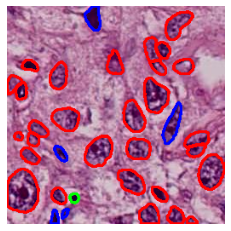

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
method = 'Reinhard'
dataset = 'Adrenal_gland'
patch = 'img_Adrenal_gland_1_01171.png'
img = mpimg.imread(PATH+method+'/hovernet/'+dataset+'/overlay/'+patch[:-3]+'png')
plt.imshow(img)
plt.axis('off')
plt.show()

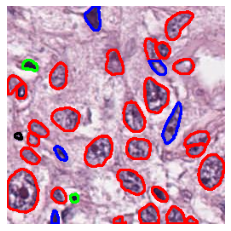

In [11]:
img = mpimg.imread(PATH+'original'+'/hovernet/'+dataset+'/overlay/'+patch[:-3]+'png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [138]:
df = pd.read_csv('/media/user/Watson/PanNuke/metrics/Classification_type_cellulaire/metrics_hover_net_classification_type_.csv')
df

,Unnamed: 0,method,dataset,f1_d,acc_type,f1_type_neoplastic,f1_type_inflammatory,f1_type_connective,f1_type_dead,f1_type_nne


In [143]:
#Avec fichiers originaux processés par hovernet  
PATH_metrics = '/home/user/Code/Etude_normalisation/PanNuke/metrics/Classification/'

for method in methods:
    df = pd.read_csv('/media/user/Watson/PanNuke/metrics/Classification_type_cellulaire/metrics_hover_net_classification_type_.csv')
    for i in list(df.columns) :
        if 'Unnamed' in i :
            df.drop(columns=i, inplace=True)
    print('-------'+method+'-------')
    for dataset in datasets:
        if dataset not in list(df[df['method'] == method]['dataset']) :
            print(dataset)
            file_list = os.listdir(PATH+method+'/hovernet/'+dataset+'/mat/')
            paired_all = []  # unique matched index pair
            unpaired_true_all = []  # the index must exist in `true_inst_type_all` and unique
            unpaired_pred_all = []  # the index must exist in `pred_inst_type_all` and unique
            true_inst_type_all = []  # each index is 1 independent data point
            pred_inst_type_all = []  # each index is 1 independent data point
            for file_idx, filename in enumerate(file_list[:]):
                #print(file_idx)
#                 filename = os.path.basename(filename)
#                 basename = filename.split(".")[0]

                true_info = sio.loadmat(PATH+'original/hovernet/'+dataset+'/mat/'+filename)
                # dont squeeze, may be 1 instance exist
                true_centroid = (true_info["inst_centroid"]).astype("float32")
                true_inst_type = (true_info["inst_type"]).astype("int32")

                if true_centroid.shape[0] != 0:
                    true_inst_type = true_inst_type[:, 0]
                else:  # no instance at all
                    true_centroid = np.array([[0, 0]])
                    true_inst_type = np.array([0])

                # * for converting the GT type in CoNSeP
                # true_inst_type[(true_inst_type == 3) | (true_inst_type == 4)] = 3
                # true_inst_type[(true_inst_type == 5) | (true_inst_type == 6) | (true_inst_type == 7)] = 4

                pred_info = sio.loadmat(PATH+method+'/hovernet/'+dataset+'/mat/'+filename)
                # dont squeeze, may be 1 instance exist
                pred_centroid = (pred_info["inst_centroid"]).astype("float32")
                pred_inst_type = (pred_info["inst_type"]).astype("int32")

                if pred_centroid.shape[0] != 0:
                    pred_inst_type = pred_inst_type[:, 0]
                else:  # no instance at all
                    pred_centroid = np.array([[0, 0]])
                    pred_inst_type = np.array([0])

                # ! if take longer than 1min for 1000 vs 1000 pairing, sthg is wrong with coord
                paired, unpaired_true, unpaired_pred = pair_coordinates(
                    true_centroid, pred_centroid, 12
                )

                # * Aggreate information
                # get the offset as each index represent 1 independent instance
                true_idx_offset = (
                    true_idx_offset + true_inst_type_all[-1].shape[0] if file_idx != 0 else 0
                )
                pred_idx_offset = (
                    pred_idx_offset + pred_inst_type_all[-1].shape[0] if file_idx != 0 else 0
                )
                true_inst_type_all.append(true_inst_type)
                pred_inst_type_all.append(pred_inst_type)

                # increment the pairing index statistic
                if paired.shape[0] != 0:  # ! sanity
                    paired[:, 0] += true_idx_offset
                    paired[:, 1] += pred_idx_offset
                    paired_all.append(paired)

                unpaired_true += true_idx_offset
                unpaired_pred += pred_idx_offset
                unpaired_true_all.append(unpaired_true)
                unpaired_pred_all.append(unpaired_pred)
#                 print('par patch', true_inst_type_all)
#                 print('par patch', np.shape(true_inst_type_all))

            paired_all = np.concatenate(paired_all, axis=0)
            unpaired_true_all = np.concatenate(unpaired_true_all, axis=0)
            unpaired_pred_all = np.concatenate(unpaired_pred_all, axis=0)
            true_inst_type_all = np.concatenate(true_inst_type_all, axis=0)
            pred_inst_type_all = np.concatenate(pred_inst_type_all, axis=0)

            
#             print(true_inst_type_all)
#             print('total', np.shape(true_inst_type_all))
#             print('np unique', np.unique(true_inst_type_all))
#             print("np.unique(true_inst_type_all).tolist()", np.unique(true_inst_type_all).tolist())

            paired_true_type = true_inst_type_all[paired_all[:, 0]]
            paired_pred_type = pred_inst_type_all[paired_all[:, 1]]
            unpaired_true_type = true_inst_type_all[unpaired_true_all]
            unpaired_pred_type = pred_inst_type_all[unpaired_pred_all]

            ###
            def _f1_type(paired_true, paired_pred, unpaired_true, unpaired_pred, type_id, w):
                type_samples = (paired_true == type_id) | (paired_pred == type_id)

                paired_true = paired_true[type_samples]
                paired_pred = paired_pred[type_samples]

                tp_dt = ((paired_true == type_id) & (paired_pred == type_id)).sum()
                tn_dt = ((paired_true != type_id) & (paired_pred != type_id)).sum()
                fp_dt = ((paired_true != type_id) & (paired_pred == type_id)).sum()
                fn_dt = ((paired_true == type_id) & (paired_pred != type_id)).sum()

                if not exhaustive:
                    ignore = (paired_true == -1).sum()
                    fp_dt -= ignore

                fp_d = (unpaired_pred == type_id).sum()
                fn_d = (unpaired_true == type_id).sum()

                f1_type = (2 * (tp_dt + tn_dt)) / (
                    2 * (tp_dt + tn_dt)
                    + w[0] * fp_dt
                    + w[1] * fn_dt
                    + w[2] * fp_d
                    + w[3] * fn_d
                )
                return f1_type

            # overall
            # * quite meaningless for not exhaustive annotated dataset
            w = [1, 1]
            tp_d = paired_pred_type.shape[0]
            fp_d = unpaired_pred_type.shape[0]
            fn_d = unpaired_true_type.shape[0]

            tp_tn_dt = (paired_pred_type == paired_true_type).sum()
            fp_fn_dt = (paired_pred_type != paired_true_type).sum()

            if not exhaustive:
                ignore = (paired_true_type == -1).sum()
                fp_fn_dt -= ignore

            acc_type = tp_tn_dt / (tp_tn_dt + fp_fn_dt)
            f1_d = 2 * tp_d / (2 * tp_d + w[0] * fp_d + w[1] * fn_d)

            w = [2, 2, 1, 1]

#             if type_uid_list is None:
#                 type_uid_list = np.unique(true_inst_type_all).tolist()
            type_uid_list = np.unique(true_inst_type_all).tolist()
            print('type_uid_list', type_uid_list)

            results_list = [f1_d, acc_type]
           # print(np.array(results_list))
            for type_uid in type_uid_list:
                f1_type = _f1_type(
                    paired_true_type,
                    paired_pred_type,
                    unpaired_true_type,
                    unpaired_pred_type,
                    type_uid,
                    w,
                )
                results_list.append(f1_type)

            np.set_printoptions(formatter={"float": "{: 0.5f}".format})
          #  print(np.array(results_list))
            data = {'method' : [method], 'dataset' : [dataset], 'f1_d' : [f1_d], 'acc_type' : [acc_type], 'f1_type_neoplastic' : [results_list[3]], 'f1_type_inflammatory' : [results_list[4]], 'f1_type_connective' : [results_list[5]], 'f1_type_dead' : [results_list[6]], 'f1_type_nne' : [results_list[7]]}
          #  data = {'method' : [method], 'dataset' : [dataset], 'f1_d' : [f1_d], 'acc_type' : [acc_type], 'f1_type_neoplastic' : [results_list[2]], 'f1_type_inflammatory' : [results_list[3]], 'f1_type_connective' : [results_list[4]], 'f1_type_dead' : [results_list[5]], 'f1_type_nne' : [results_list[6]]}
            print(data)
            df_temp = pd.DataFrame(data)
            df = pd.concat([df, df_temp])
            df.to_csv("/media/user/Watson/PanNuke/metrics/Classification_type_cellulaire/metrics_hover_net_classification_type_.csv")




-------GeomLoss_sinkhorn_target-------
Adrenal_gland
type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['GeomLoss_sinkhorn_target'], 'dataset': ['Adrenal_gland'], 'f1_d': [0.9242976624490671], 'acc_type': [0.8835266821345708], 'f1_type_neoplastic': [0.8120205757603104], 'f1_type_inflammatory': [0.6070878274268104], 'f1_type_connective': [0.6245720806390263], 'f1_type_dead': [0.375], 'f1_type_nne': [0.3939393939393939]}
Bile-duct
type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['GeomLoss_sinkhorn_target'], 'dataset': ['Bile-duct'], 'f1_d': [0.9396615941257849], 'acc_type': [0.8856172140430351], 'f1_type_neoplastic': [0.8044093851132686], 'f1_type_inflammatory': [0.7911845730027548], 'f1_type_connective': [0.7168603671888159], 'f1_type_dead': [0.49609375], 'f1_type_nne': [0.4288107202680067]}
Bladder
type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['GeomLoss_sinkhorn_target'], 'dataset': ['Bladder'], 'f1_d': [0.9314487632508834], 'acc_type': [0.8566009104704098], 'f1_type_neoplastic': [0.8055293748036

type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['Reinhard'], 'dataset': ['Breast'], 'f1_d': [0.9382194210665359], 'acc_type': [0.8606395816572808], 'f1_type_neoplastic': [0.7833336476979083], 'f1_type_inflammatory': [0.6306888491681562], 'f1_type_connective': [0.676984436641089], 'f1_type_dead': [0.21428571428571427], 'f1_type_nne': [0.7027147472796821]}
Cervix
type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['Reinhard'], 'dataset': ['Cervix'], 'f1_d': [0.9489370718271064], 'acc_type': [0.8902947305745758], 'f1_type_neoplastic': [0.8538754764930114], 'f1_type_inflammatory': [0.7405682347461574], 'f1_type_connective': [0.6654917166020444], 'f1_type_dead': [0.41042345276872966], 'f1_type_nne': [0.23054755043227665]}
Colon
type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['Reinhard'], 'dataset': ['Colon'], 'f1_d': [0.8596433712958079], 'acc_type': [0.7554634388990217], 'f1_type_neoplastic': [0.5601877872185671], 'f1_type_inflammatory': [0.6696321642429427], 'f1_type_connective': [0.5089007341848537],

type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['Ruifrok'], 'dataset': ['HeadNeck'], 'f1_d': [0.6288363308580504], 'acc_type': [0.5875767918088737], 'f1_type_neoplastic': [0.3410094823016668], 'f1_type_inflammatory': [0.4390889830508475], 'f1_type_connective': [0.17296631059983567], 'f1_type_dead': [0.12943632567849686], 'f1_type_nne': [0.07792207792207792]}
Kidney
type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['Ruifrok'], 'dataset': ['Kidney'], 'f1_d': [0.5942921096810296], 'acc_type': [0.4185499058380414], 'f1_type_neoplastic': [0.25657451112609575], 'f1_type_inflammatory': [0.256353591160221], 'f1_type_connective': [0.049601417183348095], 'f1_type_dead': [0.03982300884955752], 'f1_type_nne': [0.043478260869565216]}
Liver
type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['Ruifrok'], 'dataset': ['Liver'], 'f1_d': [0.5633751591198399], 'acc_type': [0.6660210888745427], 'f1_type_neoplastic': [0.3034894398530762], 'f1_type_inflammatory': [0.40700218818380746], 'f1_type_connective': [0.123209169054

type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['GeomLoss_sinkhorn_gradient'], 'dataset': ['Lung'], 'f1_d': [0.933631499081543], 'acc_type': [0.811633875106929], 'f1_type_neoplastic': [0.699917332598512], 'f1_type_inflammatory': [0.5702592087312415], 'f1_type_connective': [0.4607679465776294], 'f1_type_dead': [0.7482435597189696], 'f1_type_nne': [0.3076923076923077]}
Ovarian
type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['GeomLoss_sinkhorn_gradient'], 'dataset': ['Ovarian'], 'f1_d': [0.9265648102513554], 'acc_type': [0.8851063829787233], 'f1_type_neoplastic': [0.7686001229760197], 'f1_type_inflammatory': [0.6529562982005142], 'f1_type_connective': [0.73260797889878], 'f1_type_dead': [0.45569620253164556], 'f1_type_nne': [0.7504835589941973]}
Pancreatic
type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['GeomLoss_sinkhorn_gradient'], 'dataset': ['Pancreatic'], 'f1_d': [0.9261233815689262], 'acc_type': [0.7805451127819549], 'f1_type_neoplastic': [0.5122879889235029], 'f1_type_inflammatory': [0.6197

type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['model_GAN'], 'dataset': ['Testis'], 'f1_d': [0.9006260671599317], 'acc_type': [0.8293731041456016], 'f1_type_neoplastic': [0.7078374129800135], 'f1_type_inflammatory': [0.7191293428212642], 'f1_type_connective': [0.5621511922881786], 'f1_type_dead': [0.35772357723577236], 'f1_type_nne': [0.5054294175715696]}
Thyroid
type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['model_GAN'], 'dataset': ['Thyroid'], 'f1_d': [0.9114911491149115], 'acc_type': [0.7700241386877331], 'f1_type_neoplastic': [0.6456434560699964], 'f1_type_inflammatory': [0.6856127886323268], 'f1_type_connective': [0.5776991150442478], 'f1_type_dead': [0.2608695652173913], 'f1_type_nne': [0.43021766965428937]}
Uterus
type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['model_GAN'], 'dataset': ['Uterus'], 'f1_d': [0.813248863792866], 'acc_type': [0.839796782387807], 'f1_type_neoplastic': [0.7421867297643695], 'f1_type_inflammatory': [0.340080971659919], 'f1_type_connective': [0.57321076822061

Bile-duct
type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['Macenko'], 'dataset': ['Bile-duct'], 'f1_d': [0.9211888373085748], 'acc_type': [0.8929564411492122], 'f1_type_neoplastic': [0.8051599587203302], 'f1_type_inflammatory': [0.7754177286887567], 'f1_type_connective': [0.732436974789916], 'f1_type_dead': [0.41459369817578773], 'f1_type_nne': [0.44403669724770645]}
Bladder
type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['Macenko'], 'dataset': ['Bladder'], 'f1_d': [0.8396848367904808], 'acc_type': [0.892378399080812], 'f1_type_neoplastic': [0.7264833574529667], 'f1_type_inflammatory': [0.7354838709677419], 'f1_type_connective': [0.736981465136805], 'f1_type_dead': [0.225201072386059], 'f1_type_nne': [0.3076923076923077]}
Breast
type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['Macenko'], 'dataset': ['Breast'], 'f1_d': [0.9141954597706521], 'acc_type': [0.8520722157476129], 'f1_type_neoplastic': [0.718438751883568], 'f1_type_inflammatory': [0.6661033657231376], 'f1_type_connective': [0.644323244

type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['GeomLoss_sinkhorn_Average'], 'dataset': ['Colon'], 'f1_d': [0.8681782525867543], 'acc_type': [0.7101798468290165], 'f1_type_neoplastic': [0.5593011305241521], 'f1_type_inflammatory': [0.4717570252625603], 'f1_type_connective': [0.5112915785960619], 'f1_type_dead': [0.36828644501278773], 'f1_type_nne': [0.462729912875121]}
Esophagus
type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['GeomLoss_sinkhorn_Average'], 'dataset': ['Esophagus'], 'f1_d': [0.9245687091017252], 'acc_type': [0.8856003088405611], 'f1_type_neoplastic': [0.8202882685641306], 'f1_type_inflammatory': [0.6112531969309463], 'f1_type_connective': [0.7164179104477612], 'f1_type_dead': [0.46938775510204084], 'f1_type_nne': [0.15714285714285714]}
HeadNeck
type_uid_list [0, 1, 2, 3, 4, 5]
{'method': ['GeomLoss_sinkhorn_Average'], 'dataset': ['HeadNeck'], 'f1_d': [0.9086950954027404], 'acc_type': [0.738021420518602], 'f1_type_neoplastic': [0.6744550162591835], 'f1_type_inflammatory': [0.4

In [141]:
df.to_csv("/media/user/Watson/PanNuke/metrics/Classification_type_cellulaire/metrics_hover_net_classification_type_.csv")


In [144]:
df

,method,dataset,f1_d,acc_type,f1_type_neoplastic,f1_type_inflammatory,f1_type_connective,f1_type_dead,f1_type_nne
0,Vahadane,Adrenal_gland,0.902509,0.874720,0.800000,0.650530,0.570113,0.286957,0.325359
1,Vahadane,Bile-duct,0.940849,0.888180,0.821624,0.776498,0.729361,0.435897,0.466302
2,Vahadane,Bladder,0.898407,0.887490,0.800128,0.774892,0.722913,0.265896,0.387097
3,Vahadane,Breast,0.882377,0.833240,0.672594,0.623367,0.612441,0.134116,0.672046
4,Vahadane,Cervix,0.874230,0.881262,0.790086,0.712900,0.565688,0.471074,0.271062
...,...,...,...,...,...,...,...,...,...
166,GeomLoss_sinkhorn_Average,Skin,0.917202,0.722343,0.672216,0.535108,0.325163,0.283019,0.099398
167,GeomLoss_sinkhorn_Average,Stomach,0.948406,0.773718,0.707599,0.626162,0.569379,0.541304,0.119904
168,GeomLoss_sinkhorn_Average,Testis,0.933899,0.828790,0.753829,0.692407,0.622574,0.340426,0.485640
169,GeomLoss_sinkhorn_Average,Thyroid,0.950673,0.844545,0.731264,0.656716,0.684987,0.423077,0.740145


In [145]:
df_classification = df

In [146]:

df_f1_d = df_classification[['method','dataset','f1_d']]
for i, method in enumerate(methods) :
    print(method)
    df_temp = df_f1_d[df_f1_d['method']==method]
    df_temp.drop(columns='method',inplace=True)
    df_temp.rename(columns={'f1_d':method},inplace=True)
    if i == 0:
        df = df_temp
    else :
        df = pd.merge(df_temp, df, on='dataset')
    
df.to_csv('/media/user/Watson/PanNuke/metrics/Classification_type_cellulaire/df_f1_d.csv')

df_acc_type= df_classification[['method','dataset','acc_type']]
for i, method in enumerate(methods) :
    print(method)
    df_temp = df_acc_type[df_acc_type['method']==method]
    df_temp.drop(columns='method',inplace=True)
    df_temp.rename(columns={'acc_type':method},inplace=True)
    if i == 0:
        df = df_temp
    else :
        df = pd.merge(df_temp, df, on='dataset')
    
df.to_csv('/media/user/Watson/PanNuke/metrics/Classification_type_cellulaire/df_acc_type.csv')

df_f1_type = df_classification[['method','dataset','f1_type_neoplastic']]
for i, method in enumerate(methods) :
    print(method)
    df_temp = df_f1_type[df_f1_type['method']==method]
    df_temp.drop(columns='method',inplace=True)
    df_temp.rename(columns={'f1_type_neoplastic':method},inplace=True)
    if i == 0:
        df = df_temp
    else :
        df = pd.merge(df_temp, df, on='dataset')
    
df.to_csv('/media/user/Watson/PanNuke/metrics/Classification_type_cellulaire/f1_type_neoplastic.csv')

df_f1_type = df_classification[['method','dataset','f1_type_inflammatory']]
for i, method in enumerate(methods) :
    print(method)
    df_temp = df_f1_type[df_f1_type['method']==method]
    df_temp.drop(columns='method',inplace=True)
    df_temp.rename(columns={'f1_type_inflammatory':method},inplace=True)
    if i == 0:
        df = df_temp
    else :
        df = pd.merge(df_temp, df, on='dataset')
    
df.to_csv('/media/user/Watson/PanNuke/metrics/Classification_type_cellulaire/f1_type_inflammatory.csv')


df_f1_type = df_classification[['method','dataset','f1_type_connective']]
for i, method in enumerate(methods) :
    print(method)
    df_temp = df_f1_type[df_f1_type['method']==method]
    df_temp.drop(columns='method',inplace=True)
    df_temp.rename(columns={'f1_type_connective':method},inplace=True)
    if i == 0:
        df = df_temp
    else :
        df = pd.merge(df_temp, df, on='dataset')
    
df.to_csv('/media/user/Watson/PanNuke/metrics/Classification_type_cellulaire/f1_type_connective.csv')

df_f1_type = df_classification[['method','dataset','f1_type_dead']]
for i, method in enumerate(methods) :
    print(method)
    df_temp = df_f1_type[df_f1_type['method']==method]
    df_temp.drop(columns='method',inplace=True)
    df_temp.rename(columns={'f1_type_dead':method},inplace=True)
    if i == 0:
        df = df_temp
    else :
        df = pd.merge(df_temp, df, on='dataset')
    
df.to_csv('/media/user/Watson/PanNuke/metrics/Classification_type_cellulaire/f1_type_dead.csv')

df_f1_type = df_classification[['method','dataset','f1_type_nne']]
for i, method in enumerate(methods) :
    print(method)
    df_temp = df_f1_type[df_f1_type['method']==method]
    df_temp.drop(columns='method',inplace=True)
    df_temp.rename(columns={'f1_type_nne':method},inplace=True)
    if i == 0:
        df = df_temp
    else :
        df = pd.merge(df_temp, df, on='dataset')
    
df.to_csv('/media/user/Watson/PanNuke/metrics/Classification_type_cellulaire/f1_type_nne.csv')

GeomLoss_sinkhorn_target
Reinhard
Ruifrok
GeomLoss_sinkhorn_gradient
model_GAN
model_Net
Macenko
GeomLoss_sinkhorn_Average
Vahadane
GeomLoss_sinkhorn_target
Reinhard
Ruifrok
GeomLoss_sinkhorn_gradient
model_GAN
model_Net
Macenko
GeomLoss_sinkhorn_Average
Vahadane
GeomLoss_sinkhorn_target
Reinhard
Ruifrok
GeomLoss_sinkhorn_gradient
model_GAN
model_Net
Macenko
GeomLoss_sinkhorn_Average
Vahadane
GeomLoss_sinkhorn_target
Reinhard
Ruifrok
GeomLoss_sinkhorn_gradient
model_GAN
model_Net
Macenko
GeomLoss_sinkhorn_Average
Vahadane
GeomLoss_sinkhorn_target
Reinhard
Ruifrok
GeomLoss_sinkhorn_gradient
model_GAN
model_Net
Macenko
GeomLoss_sinkhorn_Average
Vahadane
GeomLoss_sinkhorn_target
Reinhard
Ruifrok
GeomLoss_sinkhorn_gradient
model_GAN
model_Net
Macenko
GeomLoss_sinkhorn_Average
Vahadane
GeomLoss_sinkhorn_target
Reinhard
Ruifrok
GeomLoss_sinkhorn_gradient
model_GAN
model_Net
Macenko
GeomLoss_sinkhorn_Average
Vahadane


/tmp/ipykernel_10138/4029572169.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.drop(columns='method',inplace=True)
/tmp/ipykernel_10138/4029572169.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.rename(columns={'f1_d':method},inplace=True)
/tmp/ipykernel_10138/4029572169.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.drop(columns='method',inplace=True)
/tmp/ipykernel_10138/4029572169.py:6: SettingW

In [147]:
#df_f1_type = pd.read_csv('df_f1_type.csv')
df_acc_type = pd.read_csv('/media/user/Watson/PanNuke/metrics/Classification_type_cellulaire/df_acc_type.csv')
df_f1_d = pd.read_csv('/media/user/Watson/PanNuke/metrics/Classification_type_cellulaire/df_f1_d.csv')


for df in [df_f1_d, df_acc_type] :
    if 'Unnamed: 0' in df.columns :
        df.drop(columns='Unnamed: 0',inplace=True)
    df.set_index('dataset',inplace=True)

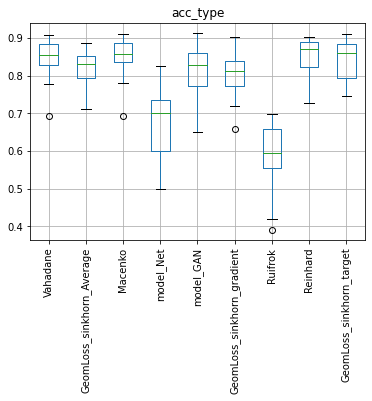

In [148]:
df_acc_type.boxplot(column=list(df_f1_d.columns))
title_boxplot = 'acc_type'
plt.title( title_boxplot )
#plt.suptitle('') # that's what you're after
plt.xticks(rotation=90)
plt.show()

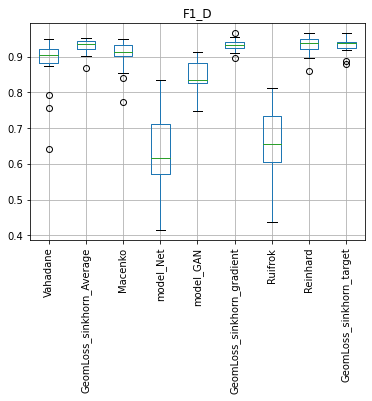

In [149]:
df_f1_d.boxplot(column=list(df_f1_d.columns))
title_boxplot = 'F1_D'
plt.title( title_boxplot )
#plt.suptitle('') # that's what you're after
plt.xticks(rotation=90)
plt.show()

In [150]:
df_f1_d.loc['median'] = df_f1_d.median()

df_f1_d = df_f1_d.sort_values(by = 'median', axis = 1) 
df_f1_d.loc['median'].round(2)

model_Net                     0.62
Ruifrok                       0.66
model_GAN                     0.84
Vahadane                      0.90
Macenko                       0.91
GeomLoss_sinkhorn_gradient    0.93
GeomLoss_sinkhorn_Average     0.93
GeomLoss_sinkhorn_target      0.94
Reinhard                      0.94
Name: median, dtype: float64

In [ ]:
import seaborn as sns
ax = sns.boxplot(data= df_zscore)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('F1_D')
PATH_savefig='/media/user/Watson/PanNuke/plot_article/Classification_type_cellulaire/'
plt.savefig(PATH_savefig+'F1_D_PanNuke_zscore.svg', format = 'svg', dpi = 20000, bbox_inches='tight')


In [ ]:
df_zscore = (df_f1_d - df_f1_d.mean())/df_f1_d.std()
df_zscore.to_csv('/media/user/Watson/PanNuke/metrics/Classification_type_cellulaire/df_f1_d_zscore.csv')


In [152]:
df_classification

,method,dataset,f1_d,acc_type,f1_type_neoplastic,f1_type_inflammatory,f1_type_connective,f1_type_dead,f1_type_nne
0,Vahadane,Adrenal_gland,0.902509,0.874720,0.800000,0.650530,0.570113,0.286957,0.325359
1,Vahadane,Bile-duct,0.940849,0.888180,0.821624,0.776498,0.729361,0.435897,0.466302
2,Vahadane,Bladder,0.898407,0.887490,0.800128,0.774892,0.722913,0.265896,0.387097
3,Vahadane,Breast,0.882377,0.833240,0.672594,0.623367,0.612441,0.134116,0.672046
4,Vahadane,Cervix,0.874230,0.881262,0.790086,0.712900,0.565688,0.471074,0.271062
...,...,...,...,...,...,...,...,...,...
166,GeomLoss_sinkhorn_Average,Skin,0.917202,0.722343,0.672216,0.535108,0.325163,0.283019,0.099398
167,GeomLoss_sinkhorn_Average,Stomach,0.948406,0.773718,0.707599,0.626162,0.569379,0.541304,0.119904
168,GeomLoss_sinkhorn_Average,Testis,0.933899,0.828790,0.753829,0.692407,0.622574,0.340426,0.485640
169,GeomLoss_sinkhorn_Average,Thyroid,0.950673,0.844545,0.731264,0.656716,0.684987,0.423077,0.740145


In [155]:
df_type = df_classification.drop(columns='dataset')
df_type = df_type.groupby('method').mean()
df_type.round(2)

,f1_d,acc_type,f1_type_neoplastic,f1_type_inflammatory,f1_type_connective,f1_type_dead,f1_type_nne
method,,,,,,,
GeomLoss_sinkhorn_Average,0.93,0.82,0.74,0.55,0.60,0.41,0.37
GeomLoss_sinkhorn_gradient,0.93,0.81,0.70,0.63,0.58,0.41,0.37
GeomLoss_sinkhorn_target,0.93,0.84,0.76,0.63,0.63,0.42,0.35
Macenko,0.91,0.85,0.75,0.65,0.64,0.39,0.36
Reinhard,0.93,0.85,0.78,0.62,0.67,0.41,0.34
Ruifrok,0.66,0.59,0.37,0.38,0.12,0.10,0.14
Vahadane,0.88,0.85,0.74,0.63,0.60,0.39,0.35
model_GAN,0.85,0.81,0.69,0.59,0.53,0.26,0.25
model_Net,0.64,0.68,0.45,0.20,0.24,0.09,0.16


In [ ]:
df_f1_type = pd.read_csv('df_f1_type.csv')
df_acc_type = pd.read_csv('df_acc_type.csv')
df_f1_d = pd.read_csv('df_f1_d.csv')

for df in [df_acc_type, df_f1_d, df_f1_type] :
    if 'Unnamed: 0' in df.columns :
        df.drop(columns='Unnamed: 0',inplace=True)
    df.set_index('dataset',inplace=True)
    
df_f1_type.loc['F1_TYPE']= df_f1_type.mean()
df_f1_type = df_f1_type[methods].reset_index()
df_f1_type = df_f1_type[df_f1_type['dataset']=='F1_TYPE']

df_acc_type.loc['ACC_TYPE']= df_acc_type.mean()
df_acc_type = df_acc_type[methods].reset_index()
df_acc_type = df_acc_type[df_acc_type['dataset']=='ACC_TYPE']

df_f1_d.loc['F1_D']= df_f1_d.mean()
df_f1_d = df_f1_d[methods].reset_index()
df_f1_d = df_f1_d[df_f1_d['dataset']=='F1_D']


df = pd.concat([df_acc_type, df_f1_d, df_f1_type])
df.drop(columns='original',inplace=True)
df.rename(columns={'dataset':'method'},inplace=True)
df.set_index('method',inplace=True)
df = df.T
df.to_csv('df_classification_global.csv')
df